<h1>Analysis and visualization of King County Animal shelter data using python</h1>

<h2>Notebook Setup</h2>

Jupyter is essentially just an advanced word processor. In this way, you can think of a notebook document as being somewhat comparable to a script file, except that it is multimedia. 

A code cell contains code to be executed and displays its output below.

Let's test it out with a classic example. 
Type "print('Hello World!')" into the cell and click the Notebook Run Button (the triangle) in the toolbar above or press Ctrl + Enter.

Hello World!


The code cell below loads the packages we will need to run the rest of the code.

In [83]:
#Sets up all required packages to use Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format='svg'
from IPython.display import display,HTML
import pandas as pd
import seaborn as sns
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from prettypandas import PrettyPandas
sns.set_style("ticks")
sns.set_context(context="notebook",font_scale=1)

<h2>Dataset</h2>

This Notebook is based on the King County, Washington "Lost, found, adoptable pets" dataset from animal shelter data. 
The [dataset](https://data.kingcounty.gov/Licenses-Permits-and-Records/Lost-found-adoptable-pets/yaai-7frk), provided by
Regional Animal Services, is available from the [King County Open Data portal](https://data.kingcounty.gov/).

The CSV contains a row (observation) for each animal. 

In [27]:
#These commands can help us change the directory we download data to, if necessary:
    #import os
    #os.chdir('../Documents/JupyterLab')
    #print(os.getcwd())

#These commands tell Python to request the data from a url and save it to a file
import requests
response = requests.get('https://data.kingcounty.gov/api/views/yaai-7frk/rows.csv?accessType=DOWNLOAD')
filename = "Lost__found__adoptable_pets.csv"
with open(filename, "wb") as f:
    f.write(response.content)  

#This command tells Pandas to place the data into a dataframe:
d = pd.read_csv('Lost__found__adoptable_pets.csv')
#print(d)

Let's have a look at the first 5 animals.

In [15]:
PrettyPandas(d                                  # Prettyprints pandas dataframes
    .head(5)                                    # Sample the first 10 rows
    [[c for c in d.columns if "Link" not in c and "Memo" not in c]] # Ignore columns with "link" in the name (they are long)
)

,impound_no,Animal_ID,Data_Source,Record_Type,Current_Location,Animal_Name,animal_type,Age,Animal_Gender,Animal_Breed,Animal_Color,Date,Date_Type,Obfuscated_Address,City,State,Zip,jurisdiction,obfuscated_latitude,obfuscated_longitude,Image,image_alt_text,Temperament
0,K18-114518,A577420,Regional Animal Services of King County,LOST,LOST,Bacardi,Cat,nan,Female,Maine Coon,Unknown,12/25/2018 12:00:00 AM,Date Lost,EAST MERCER AND SE 39TH ST,nan,nan,nan,JURISDICTION,nan,nan,https://petharbor.com/get_image.asp?RES=Detail&LOCATION=PUBLIC&ID=1944937,Image Copyright HLP Inc. 2019,nan
1,K18-114509,A577413,Regional Animal Services of King County,LOST,LOST,Bolderdash,Dog,nan,Male,American Pit Bull Terrier,Unknown,12/24/2018 12:00:00 AM,Date Lost,24400 TERRACE PL,BLACK DIAMOND,WA,98010,BLACK DIAMOND,nan,nan,https://petharbor.com/get_image.asp?RES=Detail&LOCATION=PUBLIC&ID=1944750,Image Copyright HLP Inc. 2019,nan
2,K18-111651,A566749,Regional Animal Services of King County,ADOPTABLE,In RASKC Foster Home,Rosie,Cat,13 YEARS 4 MONTHS,Female,Domestic Shorthair,Calico / Tortie,08/27/2018 12:00:00 AM,Received on,21615 64TH AVE S,KENT,WA,98032,KENT,47.4078,-122.255,https://petharbor.com/get_image.asp?RES=Detail&LOCATION=KING&ID=A566749,Image Copyright HLP Inc. 2019,GREEN
3,K18-114417,A577089,Regional Animal Services of King County,LOST,LOST,Smooky,Cat,nan,Female,Domestic Shorthair,Unknown,12/19/2018 12:00:00 AM,Date Lost,140TH AND 108TH AVE NE,nan,nan,nan,JURISDICTION,nan,nan,https://petharbor.com/get_image.asp?RES=Detail&LOCATION=PUBLIC&ID=1943386,Image Copyright HLP Inc. 2019,nan
4,K17-104325,A533907,Regional Animal Services of King County,ADOPTABLE,In RASKC Foster Home,Hera,Cat,11 YEARS -1 MONTHS,Spayed Female,Domestic Shorthair,Calico,10/28/2017 12:00:00 AM,Received on,21615 64TH AVE S,KENT,WA,98032,SEATTLE,47.4078,-122.255,https://petharbor.com/get_image.asp?RES=Detail&LOCATION=KING&ID=A533907,Image Copyright HLP Inc. 2019,nan


Let's take a look at what types of animals were turned in or found.

In [68]:
#Take a look at the data and create dataframes (subsets) for each type of animal
dog=d[d["animal_type"]=="Dog"] # dogs
cat=d[d["animal_type"]=="Cat"] # cats
rabbit=d[d["animal_type"]=="Rabbit Sh"] # rabbit
bird=d[d["animal_type"]=="Bird"] # bird

print("{} dogs ({:.1%}), {} cats ({:.1%}), {} rabbits ({:.1%}), {} birds ({:.1%})".format(
    len(dog),len(dog)/len(d),
    len(cat),len(cat)/len(d),
    len(rabbit),len(rabbit)/len(d),
    len(bird),len(bird)/len(d)))
print(type(str(d["Age"][1])))

89 dogs (42.0%), 99 cats (46.7%), 3 rabbits (1.4%), 3 birds (1.4%)
<class 'str'>


<h2>Age distribution</h2>

<h3>Data cleaning</h3>

Since the age is entered in text format, first we need to convert it to months.

In [287]:
import re

#First, extract year, month, and week from string (text) column data
d["years"] = d['Age'].str.extract('(?P<years>\d*)\s*YEAR')
d["months"] = d['Age'].str.extract('(?P<months>\d*)\s*MONTH')
d["weeks"] = d['Age'].str.extract('(?P<weeks>\d*)\s*WEEK')

#Now, convert these new variables to integers
d["years"] = pd.to_numeric(d["years"])
d["months"] = pd.to_numeric(d["months"])
d["weeks"] = pd.to_numeric(d["weeks"])

In [290]:
#Convert age in months to age in fractional years.
#Add together years, months, and weeks, replacing missing values with 0 for now
d["Age_years"] = d["years"].fillna(0) + ((d["months"].fillna(0))/12.0) + ((d["weeks"].fillna(0))/52)

#Now replace 0 values with NaN again
d["Age_years"] = d["Age_years"].replace(0,np.nan)

print(d.head(5)["Age_years"])

0          NaN
1          NaN
2    13.333333
3          NaN
4    11.083333
Name: Age_years, dtype: float64


<h3>Age outliers</h3>

There might be outliers in our data. Let's have a look at their data.

In [281]:
print("Age statistics:\n{}".format(d["Age_years"].describe()))
print()
print("There are {} animals older than 12".format((d["Age_years"]>12).sum()))
print()
print("There are {} animals younger than 1".format((d["Age_years"]<1).sum()))

Age statistics:
count    107.000000
mean       5.377726
std        4.840576
min        0.173077
25%        1.333333
50%        3.333333
75%        9.333333
max       18.166667
Name: Age_years, dtype: float64

There are 15 animals older than 12

There are 22 animals younger than 1


Apparently we have 15 animals older than 12, and 22 younger than 1. 
The maximum age is 18. Let's take a look at the very old animals.

In [86]:
PrettyPandas(d[d["Age_years"]>15][[c for c in d.columns if "Link" not in c and "Memo" not in c]])

KeyError: 'Age_years'

Let's take a look at where our dataset stands now.

In [297]:
#Now that we have added information about the animals' ages, we will want to redefine our dataframes for each type of animal:
dog=d[d["animal_type"]=="Dog"] # dogs
cat=d[d["animal_type"]=="Cat"] # cats
rabbit=d[d["animal_type"]=="Rabbit Sh"] # rabbit
bird=d[d["animal_type"]=="Bird"] # bird

print("{} dogs ({:.1%}), {} cats ({:.1%}), {} rabbits ({:.1%}), {} birds ({:.1%})".format(
    len(dog),len(dog)/len(d),
    len(cat),len(cat)/len(d),
    len(rabbit),len(rabbit)/len(d),
    len(bird),len(bird)/len(d)))
print(type(str(d["Age"][1])))

print()
print("Age statistics:\n{}".format(d["Age_years"].describe()))

89 dogs (42.0%), 99 cats (46.7%), 3 rabbits (1.4%), 3 birds (1.4%)
<class 'str'>

Age statistics:
count    107.000000
mean       5.377726
std        4.840576
min        0.173077
25%        1.333333
50%        3.333333
75%        9.333333
max       18.166667
Name: Age_years, dtype: float64


We will use this information to help us decide on a good range for our histograms and other visualizations below.

<h3>Create age histograms for dogs and cats</h3>

A histogram is a plot that lets you discover, and show, the underlying frequency distribution (shape) of a set of continuous data.

/Users/mollymking/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  *nbins*. If input is a sequence of arrays
/Users/mollymking/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  *nbins*. If input is a sequence of arrays


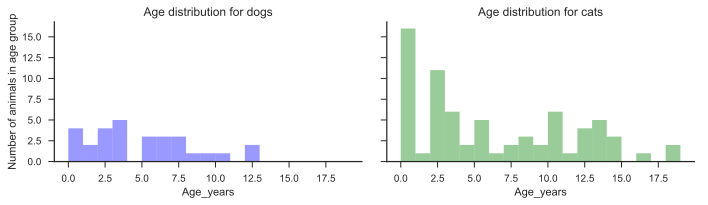

In [372]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,3),sharey=True,sharex=True)
sns.distplot(dog["Age_years"].dropna(), ax=ax1,
             bins=range(0,20), 
             kde=False,
             color="blue")
ax1.set_title("Age distribution for dogs")
sns.distplot(cat["Age_years"].dropna(), ax=ax2,
             bins=range(0,20), 
             kde=False,
             color="green")
ax2.set_title("Age distribution for cats")
ax1.set_ylabel("Number of animals in age group")
for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

NameError: name 'dog' is not defined

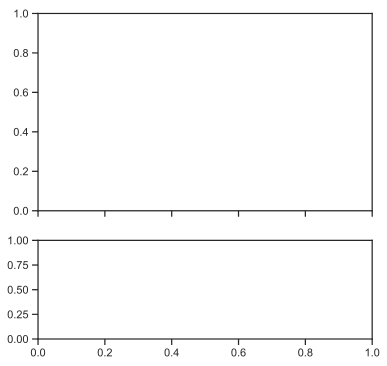

In [97]:
fig,(ax,ax2) = plt.subplots(ncols=1,nrows=2,sharex=True,figsize=(6,6),gridspec_kw={'height_ratios':[2,1]})

# Plot histograms of age
bins=range(0,20) 
sns.distplot(dog["Age_years"].dropna(), ax=ax,
             bins=bins,
             kde=False,
             color="blue",
             label="dogs")
sns.distplot(cat["Age_years"].dropna(), ax=ax,
             bins=bins,
             kde=False,
             color="green",
             label="cats")
ax.legend(loc="upper right")
ax.set_xlabel("")
ax.set_ylabel("Number of animals of a given age")
ax.set_title("Age distribution of animals");

# Make aligned boxplots
sns.boxplot(data=pd.concat([dog, cat]),  #list of data frames we are using for these plots
            y="animal_type",
            x="Age_years",
            orient="h",
            ax=ax2,
            palette={"Dog":"blue","Cat":"green"})
plt.setp(ax2.artists, alpha=.5)
ax2.set_xlim([min(bins),max(bins)])
ax2.set_xlabel("Age (years)")

#sns.despine(ax=ax)
fig.tight_layout()

<h2>Sex of Dogs and Cats</h2>

<h2>Mapping</h2>

In [29]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.geometry import Point
#import earthpy as et
#import clip_data as cl
#os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
import contextily as ctx  

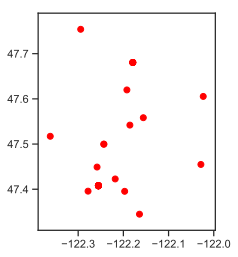

In [88]:
#Replace 0 values with NaN
d["obfuscated_longitude"] = d["obfuscated_longitude"].replace(0,np.nan)
d["obfuscated_latitude"] = d["obfuscated_latitude"].replace(0,np.nan)

#A GeoDataFrame needs a shapely object, so we create a new column Coordinates as a tuple of Longitude and Latitude :
d["Coordinates"] = list(zip(d.obfuscated_longitude, d.obfuscated_latitude))

#Then, we transform tuples to Point :
d["Coordinates"] = d["Coordinates"].apply(Point)

#Now, we can create the GeoDataFrame by setting geometry with the coordinates created previously.
gdf = gpd.GeoDataFrame(d, geometry='Coordinates')

# We can now plot our GeoDataFrame.
gdf.plot(color='red')

#Web map tiles are typically provided in Web Mercator (EPSG 3857), so we need to convert our data first
#to the same Coordinate Reference System (CRS) to combine our coordinates and background tiles in the same map
gdf.crs = {'init' :'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

In [96]:
#Let's also take a look at the Geo Dataframe :
PrettyPandas(gdf.head(5)[["animal_type","Obfuscated_Address","City","obfuscated_latitude","obfuscated_longitude","Coordinates"]])

,animal_type,Obfuscated_Address,City,obfuscated_latitude,obfuscated_longitude,Coordinates
0,Cat,EAST MERCER AND SE 39TH ST,nan,nan,nan,POINT (nan nan)
1,Dog,24400 TERRACE PL,BLACK DIAMOND,nan,nan,POINT (nan nan)
2,Cat,21615 64TH AVE S,KENT,47.4078,-122.255,POINT (-13609386.27687135 6008891.32893968)
3,Cat,140TH AND 108TH AVE NE,nan,nan,nan,POINT (nan nan)
4,Cat,21615 64TH AVE S,KENT,47.4078,-122.255,POINT (-13609386.27687135 6008891.32893968)


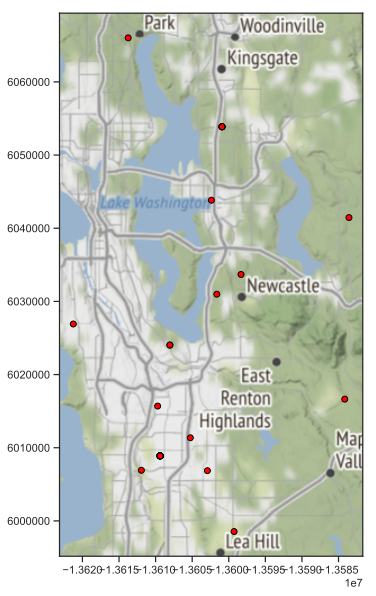

In [80]:
#Add background tiles to plot
import contextily as ctx #small helper function that uses contextily to add a map as background to an existing plot
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
# restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
#ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax = gdf.plot(figsize=(10, 10), alpha=1.0, edgecolor='k', color='red')
add_basemap(ax, zoom=10)


More precise [geocoding](http://geopandas.org/geocoding.html) could be done by getting more details on the addresses missing latitude and longitude coordinates using the [Google API](https://developers.google.com/maps/documentation/geocoding/start).

<h2>Acknowledgements</h2>

The [dataset](https://data.kingcounty.gov/Licenses-Permits-and-Records/Lost-found-adoptable-pets/yaai-7frk) is available from the [King County Open Data initiative](https://data.kingcounty.gov/).

This Notebook was developed in part based on the [Jupyter Notebook created by Alessandro Giusti and Dalle Molle](https://nbviewer.jupyter.org/github/lalelale/profiles_analysis/blob/master/profiles.ipynb).

Details about how to use Jupyter notebooks come from this website: [Jupyter Notebook for Beginners: A Tutorial](https://www.dataquest.io/blog/jupyter-notebook-tutorial/).